In [111]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataframe-cap-9/train.csv
/kaggle/input/dataframe-cap-9/test.csv
/kaggle/input/dataframe-cap-9/gender_submission.csv


**1. O primeiro passo é a avaliação da importância de cada feature que já está no banco
 de dados de teste, para isso será criada uma função que produza um gráfico indicado
 o Mutual Information Score de cada feature existente no banco de dados de treino, em
 relação ao target:**
 
 **a. Determinar quais são as features discretas; (apenas as features “Age” e “Fare”
 não são discretas);**
 
 **b. Criar a função que produza o gráfico de MI scores:**
 
 **i.Argumentos:**
 **1.features;**
 **2. arget;**
 **3.features discretas;**
 
 **ii.Gerar MI scores e produzir uma série do pandas com estes valores
 ordenados de forma descendente;**
 
 **iii.Criar um gráfico de barras que indique a pontuação de cada features;**
 
 **iv.A função deve retornar a série que contém os MI scores.**
 
 **c. Determinar quais são as features que serão utilizadas na função e o target;**
 
 **d. Produzir gráfico a partir da função e dos argumentos necessários**

**Função para calcular o MI scores:**

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

sns.set(style="whitegrid")

def plot_mi_scores(features: pd.DataFrame,
                   target: pd.Series,
                   discrete_features: list[str]) -> pd.Series:
    """
    Calcula MI para cada coluna de 'features' em relação a 'target',
    plota um gráfico de barras e retorna uma Series ordenada (desc).

    Args:
        features: DataFrame de features (antes do target).
        target: Series binária (Survived).
        discrete_features: nomes das colunas tratadas como discretas.

    Returns:
        pd.Series de MI scores indexada pelos nomes das colunas (ordem desc).
    """
    X = features.copy()

    # Codificação de categóricas: factorize em todas as colunas 'object' ou 'category'
    for col in X.columns:
        if X[col].dtype == 'object' or str(X[col].dtype).startswith('category'):
            codes, _ = pd.factorize(X[col], sort=True)
            X[col] = codes  # NaN vira -1

    # Imputação simples para NaN restantes
    for col in X.columns:
        if np.issubdtype(X[col].dtype, np.number):
            # Se ainda houver -1 de factorize, trocamos por um código próprio
            if (X[col] == -1).any():
                X[col] = X[col].replace(-1, X[col].min() - 1)
            # Preenche NaN numéricos com mediana
            if X[col].isna().any():
                X[col] = X[col].fillna(X[col].median())

    # Máscara booleana do que é discreto para o MI
    discrete_mask = [col in discrete_features for col in X.columns]

    # Cálculo do MI
    mi = mutual_info_classif(X, target, discrete_features=discrete_mask, random_state=0)
    mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=mi_series.values, y=mi_series.index, palette='viridis')
    plt.title('Mutual Information (Survived vs. features)', fontsize=14)
    plt.xlabel('MI score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return mi_series

**Seleção das features e do target**

In [113]:
# Carregar os dados
train = pd.read_csv('/kaggle/input/dataframe-cap-9/train.csv')
test = pd.read_csv('/kaggle/input/dataframe-cap-9/test.csv')

# Target
y = train['Survived']

# Usar as mesmas colunas do conjunto de teste como features
cols_features = test.columns.tolist()  # ['PassengerId','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
X = train[cols_features].copy()

# Definir features discretas (todas exceto Age e Fare)
discrete_cols = [c for c in X.columns if c not in ['Age', 'Fare']]

**Gerar o gráfico e obter a série de MI**

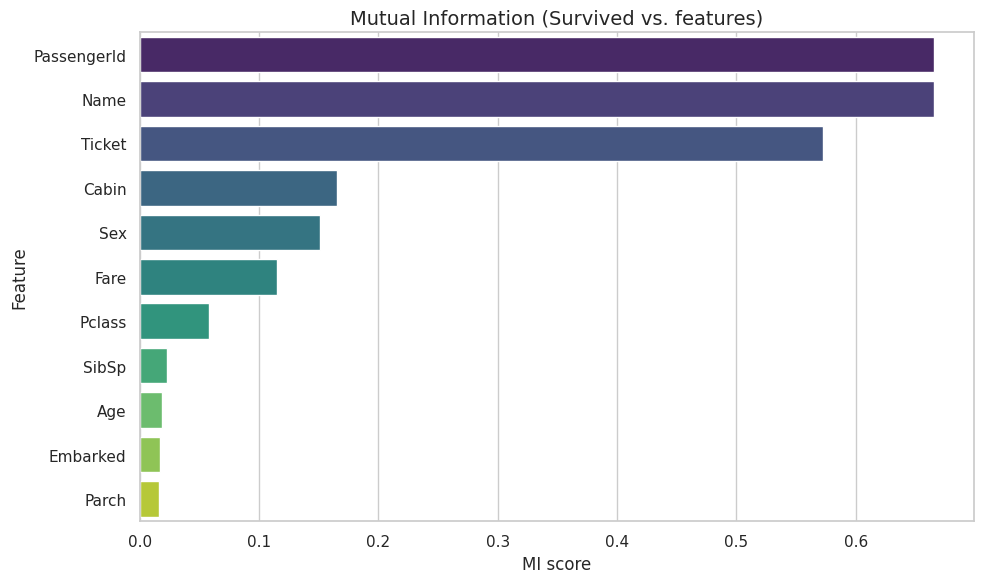

PassengerId    0.665912
Name           0.665912
Ticket         0.572496
Cabin          0.165236
Sex            0.150870
Fare           0.115435
Pclass         0.058107
SibSp          0.023197
Age            0.019060
Embarked       0.016668
dtype: float64


In [114]:
mi_scores = plot_mi_scores(X, y, discrete_cols)

# Visualizar os top 10
print(mi_scores.head(10))

**2. Após a observação do gráfico gerado é possível concluir que as features com maior influência no target são “Fare”, “Sex” e “Age”, por este motivo, elas serão analisadas mais a fundo por meio da utilização de gráficos. Para facilitar a visualização dos dados, é útil que seja usado um banco de dados que ainda contenha as features categóricas originais.**
 
**a. Construir dois gráficos do tipo sns.histplot para a análise de “Fare”:**

**i.A distribuição total das taxas;**
 
**ii.A distribuição relacionada com o target;**
 
**iii.Realize uma análise em relação à distribuição total, se a curva é normal ou não, por exemplo. Qual a influência da feature “Fare” no target que pode ser percebida a partir do segundo gráfico?**
 
**b. Agora serão criados 4 gráficos também utilizando histogramas com seaborn. Tais gráficos relacionam a Feature “Age” com “Sex”. Para facilitar a visualização é indicada a utilização de plt.subplots, para a visualização de mais de umgráfico por output:**
 
 **i.Distribuição da idade dos passageiros utilizando o sexo como camada;**
 
 **ii.A distribuição da idade dos passageiros, apenas entre os
 sobreviventes, utilizando o sexo como camada;**
 
 **iii.Distribuição da idade das mulheres, utilizando “Survived” como
 camada;**
 
 **iv.Distribuição da idade das mulheres, utilizando “Survived” como
 camada;**
 
 **v.Faça uma análise comparando a distribuição dos sobreviventes,
 comparando homens e mulheres e qual e como a idade influencia na
 chance de sobrevivência.**

**Preparação dos dados**

In [115]:
sns.set(style="whitegrid", context="notebook")

# Carregar dados
df = pd.read_csv("/kaggle/input/dataframe-cap-9/train.csv")

# Conjuntos úteis
df_fare = df[df["Fare"].notna()].copy()
df_age  = df[df["Age"].notna()].copy()

**Fare: distribuição total e por sobrevivência**

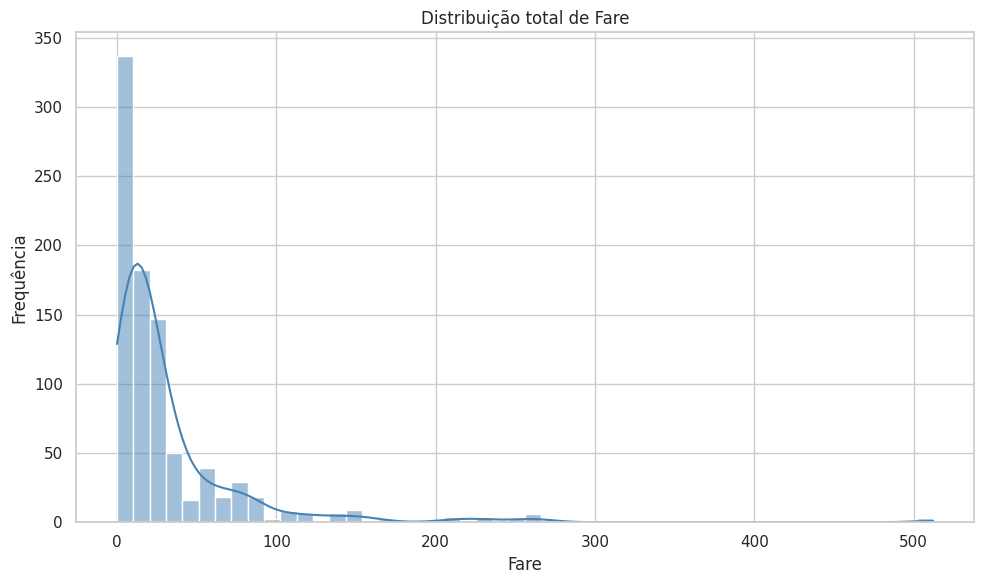

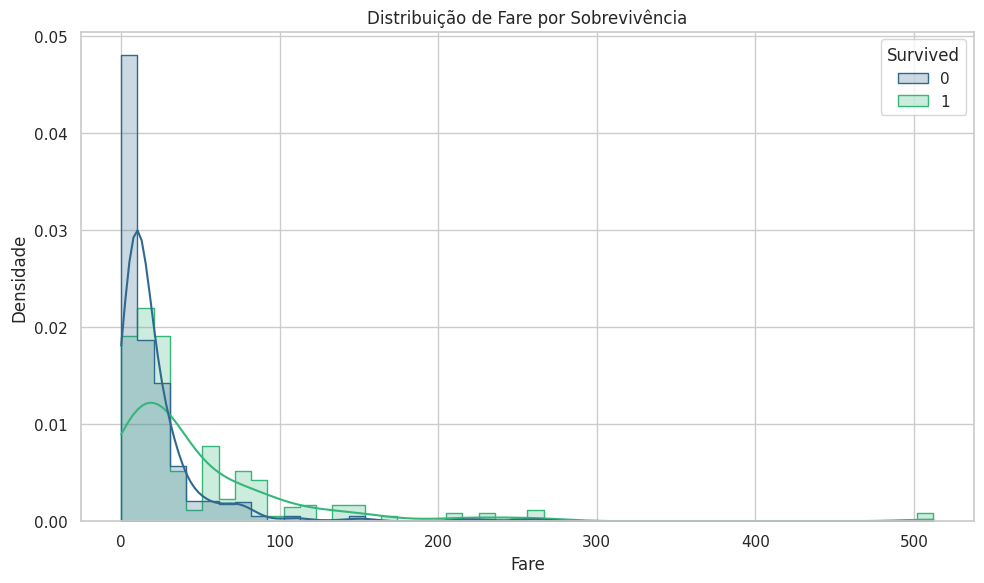

In [116]:
# a.i) Distribuição total de Fare
plt.figure(figsize=(10, 6))
sns.histplot(data=df_fare, x="Fare", bins=50, kde=True, color="steelblue")
plt.title("Distribuição total de Fare")
plt.xlabel("Fare")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

# a.ii) Distribuição de Fare por Survived
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_fare,
    x="Fare",
    hue="Survived",
    bins=50,
    kde=True,
    stat="density",
    common_norm=False,
    element="step",
    palette="viridis"
)
plt.title("Distribuição de Fare por Sobrevivência")
plt.xlabel("Fare")
plt.ylabel("Densidade")
plt.tight_layout()
plt.show()

**Análise de Fare:**

- Forma da distribuição: Claramente assimétrica à direita (cauda longa). Não é normal. A maior parte dos passageiros pagou valores baixos, com poucos outliers de tarifas muito altas. Uma transformação logarítmica em Fare tende a aproximar uma forma mais “bell-shaped”.

- Relação com o target: No gráfico por Survived, as densidades dos sobreviventes deslocam-se para valores mais altos de Fare. Em outras palavras, tarifas mais altas estão associadas a maior probabilidade de sobrevivência, refletindo a relação com a classe (1ª classe pagou mais e teve maior acesso a botes). Ainda assim, há sobreposição: alguns passageiros de tarifas baixas também sobreviveram.


**Age x Sex x Survived: quatro histogramas:**

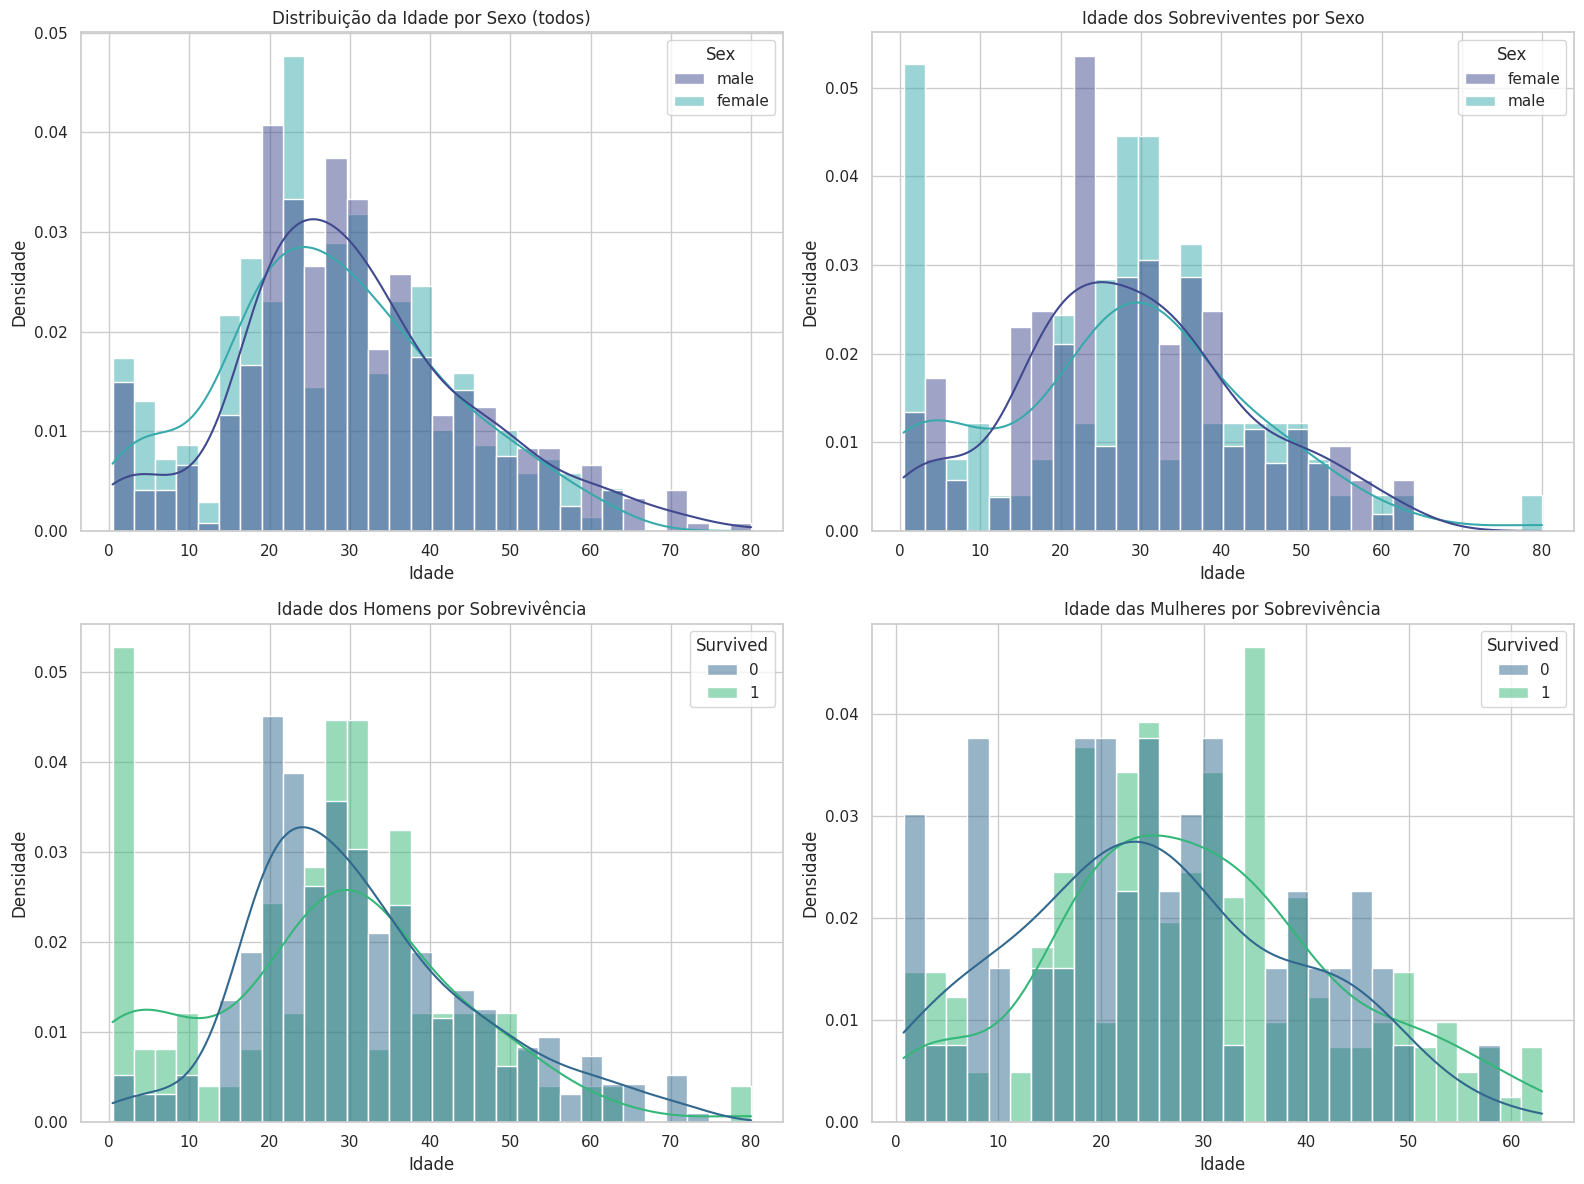

In [117]:
# Imports recomendados
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Ignora os warnings temporariamente
warnings.filterwarnings("ignore")

# Verifica se df_age possui os dados esperados
assert not df_age.empty, "O DataFrame está vazio!"
assert all(col in df_age.columns for col in ["Age", "Sex", "Survived"]), "Colunas esperadas não encontradas!"

# Criação dos subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# b.i) Distribuição da idade por sexo (todos)
sns.histplot(
    data=df_age.dropna(subset=["Age", "Sex"]),
    x="Age",
    hue="Sex",
    bins=30,
    kde=True,
    stat="density",
    common_norm=False,
    palette="mako",
    ax=axs[0, 0]
)
axs[0, 0].set(title="Distribuição da Idade por Sexo (todos)", xlabel="Idade", ylabel="Densidade")

# b.ii) Distribuição da idade dos sobreviventes por sexo
sns.histplot(
    data=df_age[(df_age["Survived"] == 1)].dropna(subset=["Age", "Sex"]),
    x="Age",
    hue="Sex",
    bins=30,
    kde=True,
    stat="density",
    common_norm=False,
    palette="mako",
    ax=axs[0, 1]
)
axs[0, 1].set(title="Idade dos Sobreviventes por Sexo", xlabel="Idade", ylabel="Densidade")

# b.iii) Idade dos homens por sobrevivência
sns.histplot(
    data=df_age[(df_age["Sex"] == "male")].dropna(subset=["Age", "Survived"]),
    x="Age",
    hue="Survived",
    bins=30,
    kde=True,
    stat="density",
    common_norm=False,
    palette="viridis",
    ax=axs[1, 0]
)
axs[1, 0].set(title="Idade dos Homens por Sobrevivência", xlabel="Idade", ylabel="Densidade")

# b.iv) Idade das mulheres por sobrevivência
sns.histplot(
    data=df_age[(df_age["Sex"] == "female")].dropna(subset=["Age", "Survived"]),
    x="Age",
    hue="Survived",
    bins=30,
    kde=True,
    stat="density",
    common_norm=False,
    palette="viridis",
    ax=axs[1, 1]
)
axs[1, 1].set(title="Idade das Mulheres por Sobrevivência", xlabel="Idade", ylabel="Densidade")

# Ajuste final e exibição
plt.tight_layout()
plt.show()

**Análise de Age x Sex x Survived:**

- Todos os passageiros (Age por Sex): Homens concentram-se mais entre 20–40 anos; mulheres apresentam distribuição semelhante, um pouco mais dispersa.

- Somente sobreviventes (Age por Sex): A massa de sobreviventes se desloca fortemente para o lado feminino em praticamente todas as idades adultas; crianças também aparecem com destaque, refletindo a prioridade “women and children first”.

- Homens (Age por Survived): Sobrevivência masculina é baixa na faixa 20–40. Crianças do sexo masculino têm melhor taxa relativa; idosos continuam com taxas baixas.

- Mulheres (Age por Survived): Sobrevivência feminina é consistentemente mais alta nas faixas adultas, com leve queda em idades muito avançadas. Entre meninas, as taxas também são altas.

- Comparação e efeito da idade na sobrevivência:

- Sexo domina o efeito: Mulheres sobrevivem muito mais do que homens em quase todas as idades.

- Crianças têm vantagem: Menores (≈0–10 anos) mostram padrões de maior sobrevivência em ambos os sexos.

- Adultos jovens do sexo masculino sofrem mais: O vale mais acentuado da sobrevivência está perto de 20–40 anos entre homens, alinhado a regras de evacuação e dinâmica de acesso a botes.

- Idosos: Tendência de menor sobrevivência geral com aumento da idade, mais evidente em homens; entre mulheres, o efeito existe, mas é menos pronunciado.


**9.2- Feature Construction**

**1. Na feature “Name” existe, para cada passageiro, um título, como “Mr” ou “Miss”. Esta
 informação pode ser útil, então podemos criar uma nova coluna para obter estes
 dados.**

**a. A partir de “Name” criar a feature “Title” para separar os valores,
 primeiramente, pela vírgula, e depois pelo ponto. Para isso deve-se utilizar o
 método str.split, lembre-se de criar uma nova coluna para armazenar estas
 informações, após isso, pode-se excluir a feature “Names”.**
 
 **2. Criar novas Features para resumir informações de outras já existentes, uma para
 indicar o número total de familiares de cada passageiro, sejam eles primos, filhos ou
 acompanhantes, e outra para informar se o passageiro está sozinho ou não.**
 
 **a. Criar feature que indique o tamanho da família, somando “SibSp” e “Parch”;**
 
 **b. Criar feature booleana indicando se o passageiro está sozinho, sendo,
 verdadeiro caso não tenha nenhum familiar a bordo, e falso caso tenha**

In [118]:
# 1. Recarrega DataFrame com 'Name' presente
df = pd.read_csv("/kaggle/input/dataframe-cap-9/train.csv")

# 2. Cria 'Title' usando str.split
df['Title'] = df['Name'].str.split(',').str[1].str.split('.').str[0].str.strip()

# 3. Remove 'Name'
df.drop(columns='Name', inplace=True)

# 4. Verifica resultado
print(df.head())

   PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch  \
0            1         0       3    male  22.0      1      0   
1            2         1       1  female  38.0      1      0   
2            3         1       3  female  26.0      0      0   
3            4         1       1  female  35.0      1      0   
4            5         0       3    male  35.0      0      0   

             Ticket     Fare Cabin Embarked Title  
0         A/5 21171   7.2500   NaN        S    Mr  
1          PC 17599  71.2833   C85        C   Mrs  
2  STON/O2. 3101282   7.9250   NaN        S  Miss  
3            113803  53.1000  C123        S   Mrs  
4            373450   8.0500   NaN        S    Mr  


**2. Criar novas Features para resumir informações de outras já existentes, uma para
 indicar o número total de familiares de cada passageiro, sejam eles primos, filhos ou
 acompanhantes, e outra para informar se o passageiro está sozinho ou não.**
 
 **a. Criar feature que indique o tamanho da família, somando “SibSp” e “Parch”;**
 
 **b. Criar feature booleana indicando se o passageiro está sozinho, sendo,
 verdadeiro caso não tenha nenhum familiar a bordo, e falso caso tenha.**

In [119]:
# Cria a nova feature 'FamilySize'
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1  # +1 para contar o próprio passageiro

# Visualiza o resultado
print(df[['SibSp', 'Parch', 'FamilySize']].head())

   SibSp  Parch  FamilySize
0      1      0           2
1      1      0           2
2      0      0           1
3      1      0           2
4      0      0           1


In [120]:
# Partindo do DataFrame df com a coluna 'FamilySize' já criada:
df['IsAlone'] = df['FamilySize'] == 1

# Visualiza algumas linhas para conferir
print(df[['SibSp', 'Parch', 'FamilySize', 'IsAlone']].head(10))

   SibSp  Parch  FamilySize  IsAlone
0      1      0           2    False
1      1      0           2    False
2      0      0           1     True
3      1      0           2    False
4      0      0           1     True
5      0      0           1     True
6      0      0           1     True
7      3      1           5    False
8      0      2           3    False
9      1      0           2    False


**9.3- Feature Extraction**

**1. No banco de dados em que estamos trabalhando existem duas features com valores
 contínuos, são "Fare' e “Age”, portanto, a partir da interação entre elas pode-se criar
 grupos utilizando K-means como forma de clustering.**

 **a. O primeiro passo é analisar a distribuição dos passageiros levando em
 consideração “Fare” e “Age”:**

 **i.Produzir um gráfico, do tipo scatter plot, colocando “Age” e “Fare” como
 eixos.**
 

**ii.Nesta distribuição é possível identificar outliers, esses valores devem
 ser retirados para que o algoritmo k-means, encontre os grupos da
 maneira correta. Como esses valores podem ser retirados?**

 **b. Agora será necessário criar os grupos utilizando a biblioteca K-means do
 sklearn:**

 **i.Crie um dataframe que contenha apenas as features “Age” e “Fare”,
 para remover os outliers, selecione apenas os passageiros que tenham
 as taxas menores que 500;**

 **ii.Crie um algoritmo k-means que produza 6 grupos;**

 **iii.Utilizando este algoritmo, produza uma nova coluna no dataframe
 criado, contendo os grupos de cada passageiro;**

 **c. Agora será útil entender quais as características de cada grupo criado pelo
 algoritmo, para isso serão utilizados dois gráficos, um para identificar os
 grupos na distribuição “Age” x “Fare”, outro para avaliá-los em relação à
 chance de sobrevivência:**

**i. Adicionar a nova feature ao banco de dados de treino;**

**ii. Construir um gráfico scatter plot que mostra a distribuição “Fare” x
 “Age”, tendo os grupos como camadas;**

**iii. Um gráfico bar chart que indique a chance de sobrevivência, em média,
 de cada grupo;**

 **iv. Faça uma análise qualitativa do que cada grupo representa e discuta
 sobre as chances de sobrevivência médias.**

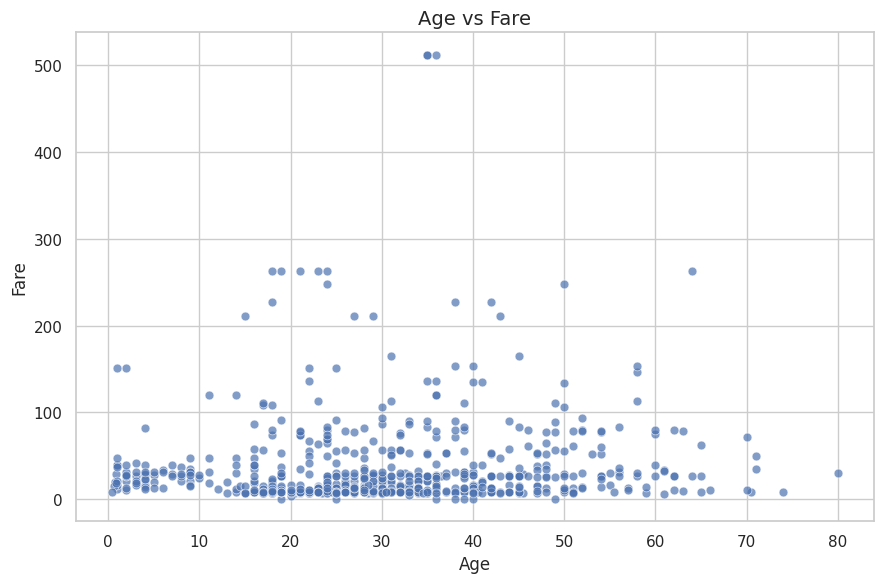

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

#Gráfico Age vs Fare:

# Supondo que seu DataFrame seja 'df' e contenha as colunas 'Age' e 'Fare'
plot_df = df[['Age', 'Fare']].dropna()

sns.set(style='whitegrid')
plt.figure(figsize=(9, 6))
sns.scatterplot(data=plot_df, x='Age', y='Fare', s=40, alpha=0.7)
plt.title('Age vs Fare', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Fare', fontsize=12)
plt.tight_layout()
plt.show()

**Retirando os otliers, o método usado ser IQR(Interquartile Range):**

In [122]:
def remove_outliers_iqr(df, col):
    # Remove temporariamente linhas onde a coluna é NaN
    df_sem_na = df.dropna(subset=[col])
    
    Q1 = df_sem_na[col].quantile(0.25)
    Q3 = df_sem_na[col].quantile(0.75)
    IQR = Q3 - Q1
    
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Filtra apenas valores dentro dos limites
    df_filtrado = df_sem_na[
        (df_sem_na[col] >= limite_inferior) &
        (df_sem_na[col] <= limite_superior)
    ]
    
    return df_filtrado

# Aplicando em Age e depois em Fare
df_sem_outliers = remove_outliers_iqr(df, 'Age')
df_sem_outliers = remove_outliers_iqr(df_sem_outliers, 'Fare')

#Ver o antes e depois os dois dataframes:

print("Antes:", df.shape)
print("Depois:", df_sem_outliers.shape)

Antes: (891, 14)
Depois: (607, 14)


**Comparativo age vs fare depois do efeito de limpeza:**

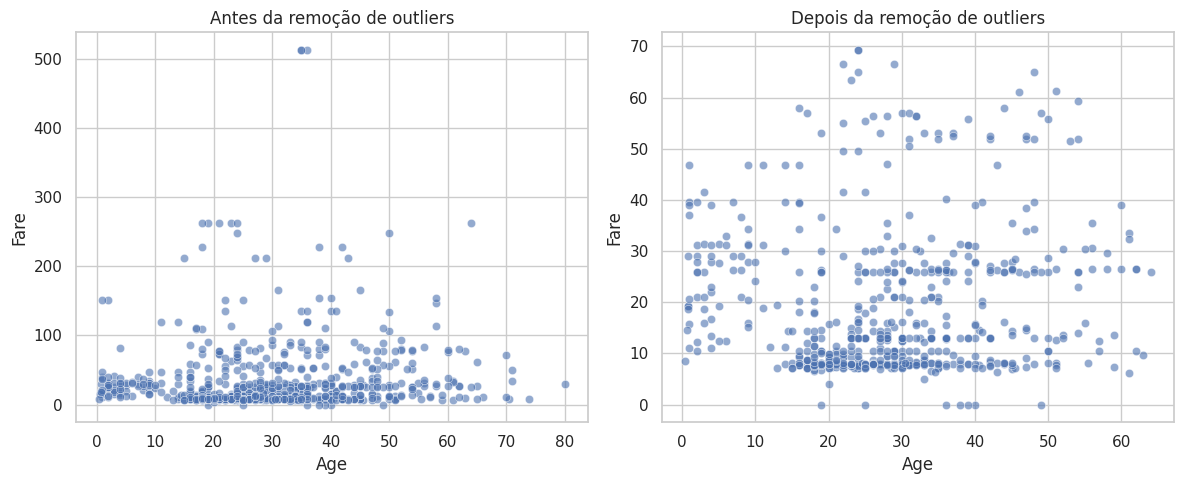

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='Age', y='Fare', alpha=0.6)
plt.title('Antes da remoção de outliers')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_sem_outliers, x='Age', y='Fare', alpha=0.6)
plt.title('Depois da remoção de outliers')

plt.tight_layout()
plt.show()

In [124]:
import pandas as pd

# Caso df já esteja carregado, use-o diretamente. 
# Se precisar carregar:
# df = pd.read_csv("/kaggle/input/dataframe-cap-9/train.csv")

# Seleciona apenas Age e Fare
df_age_fare = df.loc[:, ['Age', 'Fare']].copy()

# Converte para numérico
df_age_fare['Age'] = pd.to_numeric(df_age_fare['Age'], errors='coerce')
df_age_fare['Fare'] = pd.to_numeric(df_age_fare['Fare'], errors='coerce')

# Remove NaN
df_age_fare = df_age_fare.dropna(subset=['Age', 'Fare'])

# Filtro para Age < 500 e Fare < 500
df_age_fare_no_outliers = df_age_fare[
    (df_age_fare['Age'] < 500) & (df_age_fare['Fare'] < 500)
].copy()

# Conferência
print("Antes:", df_age_fare.shape)
print("Depois:", df_age_fare_no_outliers.shape)

Antes: (714, 2)
Depois: (711, 2)


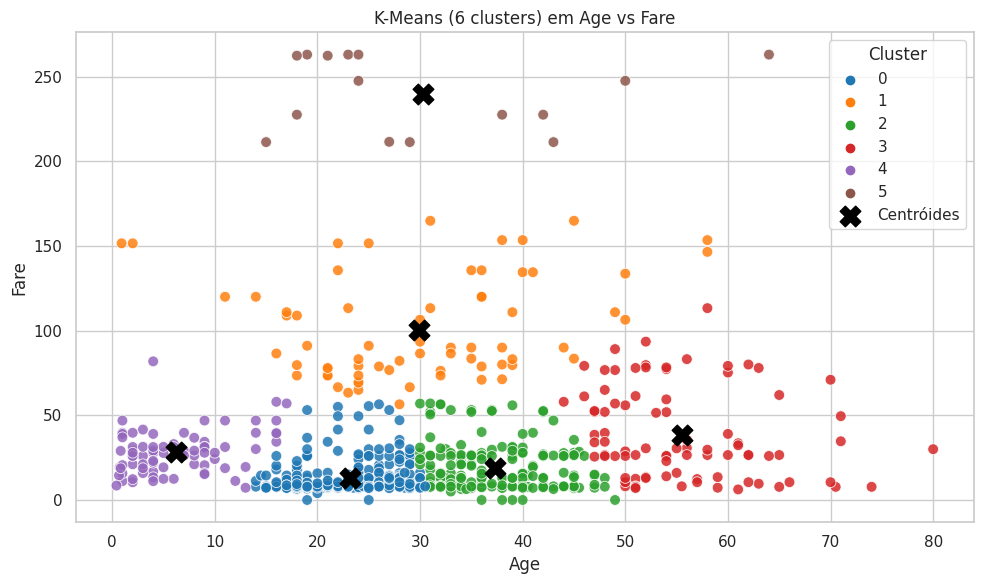

Tamanho dos clusters:
Cluster
0    282
1     68
2    182
3     87
4     77
5     15
Name: count, dtype: int64 

Centróides (escala original):
         Age_center  Fare_center
Cluster                         
0             23.17        13.24
1             29.93       100.59
2             37.29        19.03
3             55.53        38.51
4              6.24        28.20
5             30.33       239.99


In [125]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Matriz de features e padronização
X = df_age_fare_no_outliers[['Age', 'Fare']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2) K-Means com 6 clusters
kmeans = KMeans(n_clusters=6, n_init=20, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# 3) Anexa rótulos e calcula centróides na escala original
df_clusters = df_age_fare_no_outliers.copy()
df_clusters['Cluster'] = labels

centroids_orig = scaler.inverse_transform(kmeans.cluster_centers_)

# 4) Visualização
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clusters,
    x='Age', y='Fare',
    hue='Cluster',
    palette='tab10',
    s=60, alpha=0.85
)
plt.scatter(
    centroids_orig[:, 0], centroids_orig[:, 1],
    s=220, c='black', marker='X', label='Centróides'
)
plt.title('K-Means (6 clusters) em Age vs Fare')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# 5) Resumo
print("Tamanho dos clusters:")
print(df_clusters['Cluster'].value_counts().sort_index(), '\n')

centroids_df = pd.DataFrame(centroids_orig, columns=['Age_center', 'Fare_center'])
centroids_df.index.name = 'Cluster'
print("Centróides (escala original):")
print(centroids_df.round(2))

In [126]:
#Adicionando a coluna de grupos ao DataFrame:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1) Seleciona as features
X = df_age_fare_no_outliers[['Age', 'Fare']].values

# 2) Padroniza (importante para K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) Ajusta o K-Means e obtém os rótulos
kmeans = KMeans(n_clusters=6, n_init=20, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# 4) Cria a coluna de grupos no DataFrame
df_age_fare_no_outliers['Grupo'] = labels

# (Opcional) transformar em categoria e visualizar contagem por grupo
df_age_fare_no_outliers['Grupo'] = df_age_fare_no_outliers['Grupo'].astype('category')
print(df_age_fare_no_outliers['Grupo'].value_counts().sort_index())

Grupo
0    282
1     68
2    182
3     87
4     77
5     15
Name: count, dtype: int64


**Letra c:**

**i:**

In [127]:
# Supondo que 'df' é o DataFrame original de treino
df['Grupo'] = pd.NA
df.loc[df_age_fare_no_outliers.index, 'Grupo'] = df_age_fare_no_outliers['Grupo']
df['Grupo'] = df['Grupo'].astype('category')

print(df['Grupo'].value_counts(dropna=False).sort_index())

Grupo
0      282
1       68
2      182
3       87
4       77
5       15
NaN    180
Name: count, dtype: int64


**ii:**

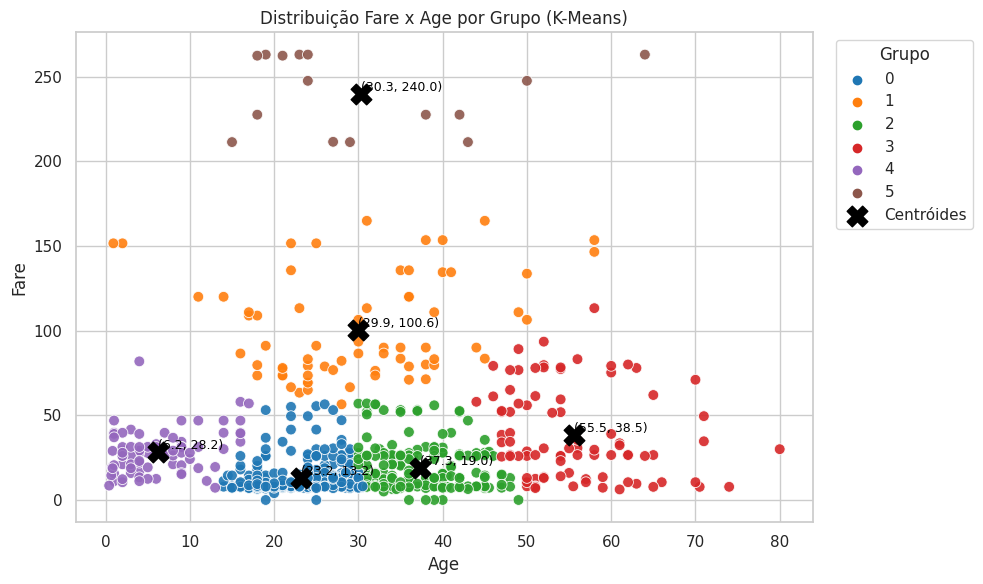

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data=df_age_fare_no_outliers.dropna(subset=['Age','Fare','Grupo']),
    x='Age', y='Fare',
    hue='Grupo', palette='tab10',
    s=60, alpha=0.9
)

# (Opcional) sobrepor centróides na escala original se você tiver 'kmeans' e 'scaler'
try:
    centroids_orig = scaler.inverse_transform(kmeans.cluster_centers_)
    plt.scatter(centroids_orig[:, 0], centroids_orig[:, 1],
                s=220, c='black', marker='X', label='Centróides')
    for x, y in centroids_orig:
        plt.text(x, y, f'({x:.1f}, {y:.1f})', color='black',
                 ha='left', va='bottom', fontsize=9)
except Exception:
    pass  # segue sem centróides se não estiverem no ambiente

plt.title('Distribuição Fare x Age por Grupo (K-Means)')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.legend(title='Grupo', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

**iii:**

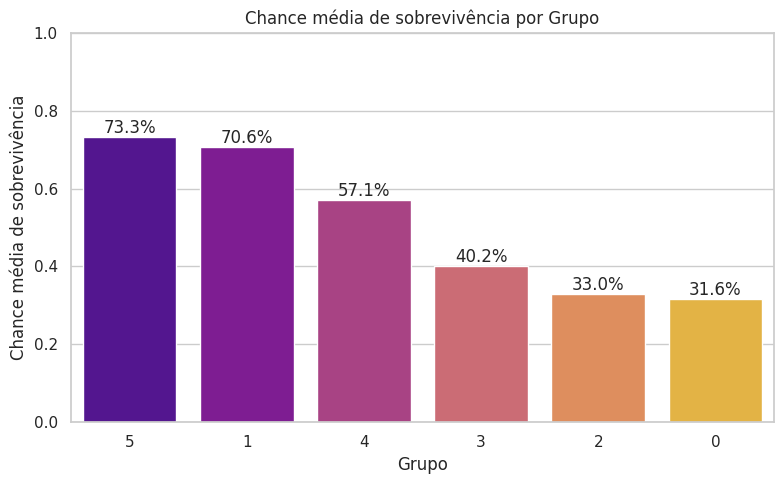

Taxas médias de sobrevivência por grupo:
Grupo
5    73.3%
1    70.6%
4    57.1%
3    40.2%
2    33.0%
0    31.6%
Name: Survived, dtype: object


In [129]:
# Garante que temos Survived e Grupo
df_surv = df.dropna(subset=['Survived','Grupo']).copy()

# Taxa média de sobrevivência por grupo
survival_rates = (
    df_surv.groupby('Grupo')['Survived']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=survival_rates.index.astype(str),
    y=survival_rates.values,
    palette='plasma'
)
ax.bar_label(ax.containers[0], labels=[f'{v*100:.1f}%' for v in survival_rates.values])
plt.title('Chance média de sobrevivência por Grupo')
plt.ylabel('Chance média de sobrevivência')
plt.xlabel('Grupo')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print('Taxas médias de sobrevivência por grupo:')
print((survival_rates*100).round(1).astype(str) + '%')

**iii:**

**Leitura qualitativa dos grupos:**

**Perfil por centróide: - Cada cluster tem um centróide com uma combinação típica de idade e tarifa. Em geral, centróides com Fare alto refletem passageiros de classes mais altas; centróides com Age baixo refletem crianças/jovens.**

**Grupos de alta sobrevivência média: Tendem a concentrar-se em Fares mais altos (proxy de Pclass superior) e/ou idades menores (crianças receberam prioridade nos botes). Esses grupos costumam apresentar barras mais altas no gráfico de sobrevivência.**

**Grupos de baixa sobrevivência média: Frequentemente associados a Fares baixos (classes mais baixas) e adultos. Mesmo sem usar “Sex” no clustering, a taxa de sobrevivência costuma ser menor nesses perfis.**

**Tamanho dos grupos: Grupos muito pequenos podem ter média instável; vale olhar a contagem por cluster para contextualizar as taxas.**

**Atenção a variáveis não usadas no cluster: Como o K‑Means foi feito só com Age e Fare, diferenças de sobrevivência também refletem variáveis correlatas (ex.: Pclass via Fare). Para conclusões mais sólidas, vale cruzar os grupos com “Sex” e “Pclass”.**


**2. Ao analisarmos a nova feature, é fácil notar que existem valores nulos, estes valores
 correspondem aos outliers que foram retirados para a construção dos grupos. Para
 substituir os NaN, deve-se identificar quem são esses outliers e designar,
 manualmente, seu grupo:**

**a. Identifique quem são os outliers;**

**i.Utilize o método .loc do pandas para localizar as linhas onde ocorrem
 os valores nulos da nova feature;**

**ii. Analise as características destes passageiros e defina qual grupo
 melhor encaixam.**

 **b. Substitua os valores nulos da nova feature pelo grupo em que melhor se
 encaixam;**

 **i.Obtenha novamente as linhas que contém NaN e substitua apenas o
 valor da nova feature;**
 
 **ii.Observe se os valores foram substituídos de forma adequada
 realizando o print das linhas editadas.**
 

**letra a, i:**

In [130]:
# Identifica os passageiros sem grupo (valores nulos em 'Grupo')
#usa .loc indiretamente com a máscara mask_out para localizar os registros com Grupo = NaN

mask_out = df['Grupo'].isna()

**letra a, ii:**

In [131]:
# Exibe os dados dos passageiros sem grupo para análise
#permite visualizar os dados dos outliers e entender suas características.
display(df.loc[mask_out, ['Pclass','Sex','Age','Fare']])

,Pclass,Sex,Age,Fare
5,3,male,NaN,8.4583
17,2,male,NaN,13.0000
19,3,female,NaN,7.2250
26,3,male,NaN,7.2250
28,3,female,NaN,7.8792
...,...,...,...,...
859,3,male,NaN,7.2292
863,3,female,NaN,69.5500
868,3,male,NaN,9.5000
878,3,male,NaN,7.8958


**letra b: i, ii:**

In [132]:
if mask_out.sum() > 0:
    # Filtra dados válidos para calcular centróides
    df_validos = df.loc[~df['Grupo'].isna(), ['Grupo','Age','Fare']].copy()
    df_validos['Grupo'] = df_validos['Grupo'].astype(int)

    # Calcula centróides por grupo
    centroides = df_validos.groupby('Grupo')[['Age','Fare']].mean()

    # Seleciona os passageiros sem grupo
    candidatos = df.loc[mask_out, ['Age','Fare']].copy()

    # Imputa valores faltantes com mediana
    candidatos['Age'] = candidatos['Age'].fillna(df['Age'].median())
    candidatos['Fare'] = candidatos['Fare'].fillna(df['Fare'].median())

    # Atribui grupo mais próximo com base na distância aos centróides
    grupos_atribuidos = []
    for _, row in candidatos.iterrows():
        distancias = np.linalg.norm(centroides - row.values, axis=1)
        grupo_mais_proximo = centroides.index[np.argmin(distancias)]
        grupos_atribuidos.append(grupo_mais_proximo)

    # Substitui os valores nulos da feature 'Grupo'
    df.loc[mask_out, 'Grupo'] = grupos_atribuidos
    df['Grupo'] = df['Grupo'].astype('category')

    # Letra b, ii: Verifica se ainda restam valores nulos e exibe os registros atualizados
    print("Restam NaN em Grupo:", df['Grupo'].isna().sum())
    display(df.loc[mask_out, ['Pclass','Sex','Age','Fare','Grupo']])
else:
    print("Não há registros sem Grupo para processar.")

Restam NaN em Grupo: 0


,Pclass,Sex,Age,Fare,Grupo
5,3,male,NaN,8.4583,0
17,2,male,NaN,13.0000,0
19,3,female,NaN,7.2250,0
26,3,male,NaN,7.2250,0
28,3,female,NaN,7.8792,0
...,...,...,...,...,...
859,3,male,NaN,7.2292,0
863,3,female,NaN,69.5500,1
868,3,male,NaN,9.5000,0
878,3,male,NaN,7.8958,0


**3. Agora avalie, utilizando mutual information, se a nova feature é significativa para a
 previsão do target (Utilize os passos mostrados em 9.1- 1).**

In [133]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Garante que não há NaN no target ou na feature
df_mi = df.dropna(subset=['Survived', 'Grupo']).copy()

# Mutual Information espera que a feature seja numérica
X = df_mi[['Grupo']].astype(int)  # converte categoria para int
y = df_mi['Survived'].astype(int)

# Calcula a informação mútua
mi_score = mutual_info_classif(X, y, discrete_features=True)

print(f"Mutual Information (Grupo vs Survived): {mi_score[0]:.4f}")

Mutual Information (Grupo vs Survived): 0.0354


In [134]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Seleção das features
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Grupo']

# Cria cópia somente com Survived e as features
df_enc = df[features + ['Survived']].copy()

# Converte variáveis categóricas para numéricas
df_enc['Sex'] = df_enc['Sex'].astype('category').cat.codes
df_enc['Grupo'] = df_enc['Grupo'].astype(int)

# Remove linhas com valores faltantes em qualquer coluna usada
df_enc = df_enc.dropna(subset=features + ['Survived'])

# Define X e y
X_all = df_enc[features]
y_all = df_enc['Survived'].astype(int)

# Lista booleana de quais features são discretas
discrete_mask = [True, True, False, False, True]  # Pclass, Sex, Grupo = True; Age e Fare = False

# Calcula a mutual information
mi_scores = mutual_info_classif(X_all, y_all, discrete_features=discrete_mask)

# Cria ranking
mi_df = pd.Series(mi_scores, index=features).sort_values(ascending=False)
print(mi_df)

Sex       0.149731
Fare      0.131263
Pclass    0.066321
Grupo     0.040763
Age       0.003202
dtype: float64


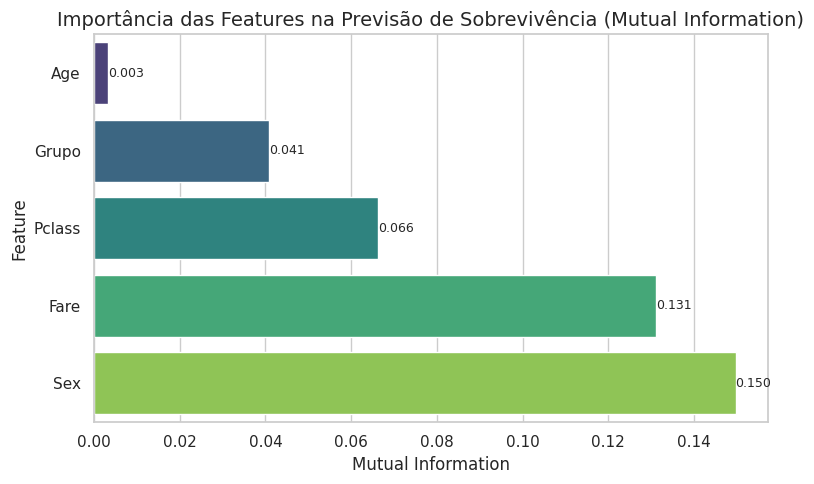

In [135]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supondo que 'mi_df' seja um Series com índice = nome das features e valores = MI
# Exemplo: mi_df = pd.Series(mi_scores, index=features)

# Se ainda não for DataFrame, converte para facilitar o plot
mi_plot_df = mi_df.reset_index()
mi_plot_df.columns = ['Feature', 'Mutual Information']

# Estilo do gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Gráfico de barras horizontal
ax = sns.barplot(
    x='Mutual Information',
    y='Feature',
    data=mi_plot_df.sort_values('Mutual Information', ascending=True),
    palette='viridis'
)

# Título e rótulos
ax.set_title('Importância das Features na Previsão de Sobrevivência (Mutual Information)', fontsize=14)
ax.set_xlabel('Mutual Information', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)

# Adiciona rótulos de valor nas barras
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=9)

plt.tight_layout()
plt.show()

**4. As features originais não representam a mesma grandeza, “Age” conta a idade em
 anos e “Fare” a taxa de embarque em dólares, portanto, para que seja possível utilizar
 o PCA, deve-se primeiramente realizar os Scaling das variáveis. Para esta etapa será
 utilizado o MinMax Scaler do scikit learn:**

 **a. Scaling das features “Age” e “Fare”, entre 0 e 1:**

**i.Criar um scaler utilizando minmax scaler;**

**ii.Criar um dataframe para armazenar as features após o Scaling;**

**iii. Criar um loop que passe pelas duas features que serão escaladas:**

**1. Produzir uma coluna no novo dataframe que contenha a
 respectiva coluna do banco de dados de treino;** 

**2. Ajustar e transformar a nova coluna utilizando o minmax scaler.**

**b. Para garantir que o processo foi realizado com sucesso agora deve-se
 visualizar as duas colunas, elas devem ter seus valores entre 0 e 1 e manter
 sua forma original.**

 **i. Fazer um histograma com a coluna “Age” do novo dataframe;**

 **ii. Fazer um histograma com a coluna “Fare” do novo dataframe.**

 

**letra a:**

In [136]:
#a.i) Criar um scaler utilizando MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Criar o scaler
scaler = MinMaxScaler()

In [137]:
#a.ii) Criar um DataFrame para armazenar as features após o Scaling

# Criar DataFrame vazio para armazenar as features escaladas
df_scaled = pd.DataFrame()

In [138]:
#a.iii) Loop pelas duas features a serem escaladas

# Lista de colunas a serem escaladas
features_to_scale = ['Age', 'Fare']

for feature in features_to_scale:
    # 1. Copiar a coluna original para o novo DataFrame
    df_scaled[feature] = df[feature]
    
    # 2. Ajustar e transformar usando o MinMaxScaler
    df_scaled[feature] = scaler.fit_transform(df[[feature]])

**b. Garantir que o processo foi realizado com sucesso:**

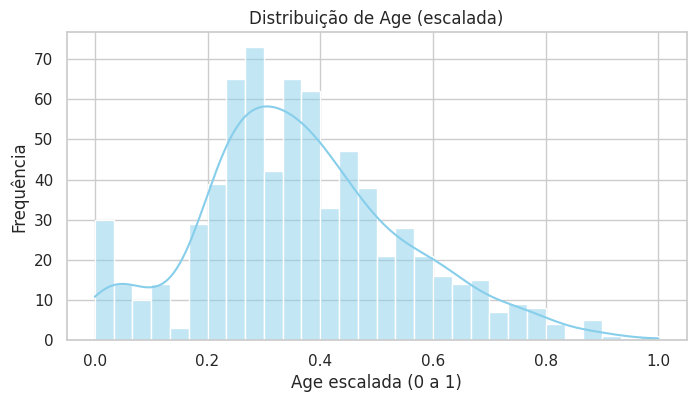

In [139]:
#b.i) Histograma da coluna “Age” escalada:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(df_scaled['Age'], bins=30, kde=True, color='skyblue')
plt.title('Distribuição de Age (escalada)')
plt.xlabel('Age escalada (0 a 1)')
plt.ylabel('Frequência')
plt.show()

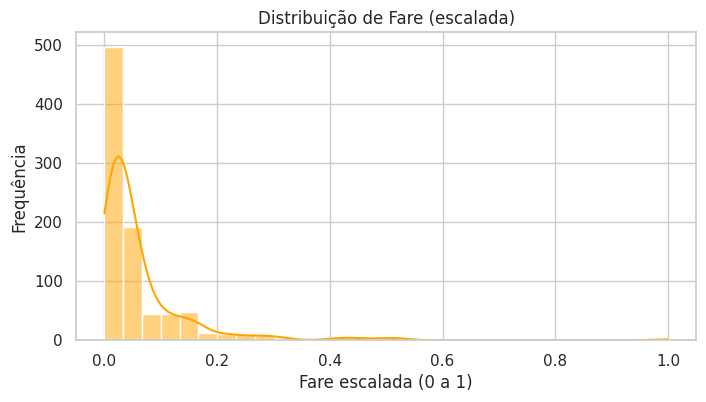

In [140]:
#b.ii) Histograma da coluna “Fare” escalada

plt.figure(figsize=(8,4))
sns.histplot(df_scaled['Fare'], bins=30, kde=True, color='orange')
plt.title('Distribuição de Fare (escalada)')
plt.xlabel('Fare escalada (0 a 1)')
plt.ylabel('Frequência')
plt.show()

**5. Agora já é possível realizar o PCA, contudo, não há garantias que esta estratégia trará
 novas informações úteis para o modelo, portanto, é necessário, após a criação dos
 novos eixos, analisar criticamente se vale a pena introduzi-los ao banco de dados.**

 **a. Realizar o PCA no dataframe com features escaladas:**

**i. Criar um PCA utilizando a biblioteca do sklearn;**
 
**ii.Ajustar e transformar o dataframe com features escaladas utilizando
 PCA;**
 
**iii. Criar um dataframe com os novos dados após a transformação com
 PCA;**
 
**iv.Criar um dataframe com os valores que foram multiplicados os eixos
 das features “Age” e “Fare”;**

**v.A partir dos valores do item iv, analise se os eixos foram significamente
 alterados, se sim, descreva qual a nova relação que se pode perceber
 entre as duas features.**


In [141]:
#Letra a, i:

from sklearn.decomposition import PCA

# Criar um PCA para 2 componentes (porque temos Age e Fare)
pca = PCA(n_components=2)

In [142]:
#Letra a, ii:

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import pandas as pd

# Supondo que df_scaled já exista e tenha as colunas 'Age' e 'Fare'

# 1. Criar um imputador para substituir NaN pela média
imputer = SimpleImputer(strategy='mean')

# 2. Ajustar e transformar os dados sem NaN
age_fare_imputed = imputer.fit_transform(df_scaled[['Age', 'Fare']])

# 3. Criar o PCA
pca = PCA(n_components=2)

# 4. Ajustar e transformar
pca_components = pca.fit_transform(age_fare_imputed)


In [143]:
#letra a, iii:
import pandas as pd

# Criar DataFrame com os componentes principais
df_pca = pd.DataFrame(
    pca_components,
    columns=['PCA1', 'PCA2'],
    index=df_scaled.index
)

print(df_pca.head())


       PCA1      PCA2
0 -0.100459 -0.040502
1  0.110285  0.067348
2 -0.050259 -0.043365
3  0.069769  0.035111
4  0.062464 -0.052517


In [144]:
#letra a, iv:

# Os loadings são as combinações lineares (coeficientes) de cada variável nos componentes
loadings = pd.DataFrame(
    pca.components_,
    columns=['Age', 'Fare'],
    index=['PCA1', 'PCA2']
)

print("Loadings dos componentes principais:")
print(loadings)

Loadings dos componentes principais:
           Age      Fare
PCA1  0.996543  0.083074
PCA2 -0.083074  0.996543


In [145]:
#Análise crítica:

# Variância explicada por cada componente
print("\nVariância explicada:")
print(pca.explained_variance_ratio_)

# Interpretação simples
if abs(loadings.loc['PCA1', 'Age']) > abs(loadings.loc['PCA1', 'Fare']):
    print("\nPCA1 é mais influenciado por Age.")
else:
    print("\nPCA1 é mais influenciado por Fare.")

if abs(loadings.loc['PCA2', 'Age']) > abs(loadings.loc['PCA2', 'Fare']):
    print("PCA2 é mais influenciado por Age.")
else:
    print("PCA2 é mais influenciado por Fare.")


Variância explicada:
[0.74275453 0.25724547]

PCA1 é mais influenciado por Age.
PCA2 é mais influenciado por Fare.


**6. Agora, o último passo será avaliar a nova feature criada pelo PCA, utilizando o mesmo
 processo encontrado no curso de Feature Engineering do kaggle, no capítulo Principal
 Component Analysis. É viável, com essas técnicas, a substituição das features “Fare”
 e “Age” por apenas uma?**

In [146]:
print("Variância explicada por cada componente:", pca.explained_variance_ratio_)
print("Variância explicada acumulada:", pca.explained_variance_ratio_.cumsum())
#O primeiro valor mostra o quanto do padrão conjunto de Age e Fare já foi capturado no eixo PCA1
#- O .cumsum() indica a variância total acumulada conforme vamos incluindo mais componentes.


Variância explicada por cada componente: [0.74275453 0.25724547]
Variância explicada acumulada: [0.74275453 1.        ]


Critério de viabilidade
- Se PCA1 explicar muito (por exemplo, ≥ 90%) da variância total, ele sozinho já retém quase toda a informação das duas colunas — isso torna plausível substituir Age e Fare por apenas uma feature (PCA1).
- Se ficar abaixo desse patamar (por exemplo, 70%, 80%), significa que a segunda componente (PCA2) ainda guarda informação relevante; eliminar uma pode implicar perda considerável de sinal.

Exemplo de interpretação
Suponha que seu PCA retorne algo como:
Variância explicada por cada componente: [0.93 0.07]


- PCA1 sozinho captura 93% da variabilidade — nesse caso, é viável substituir Age e Fare por um único eixo (PCA1).
- PCA2 explicando só 7% significa que esse eixo acrescenta pouco à representação dos dados.
Outro cenário:
Variância explicada por cada componente: [0.75 0.25]


- PCA1 captura 75% — ainda é alto, mas 25% pode não ser desprezível, então a decisão dependeria de testes de performance no modelo final.

Resposta direta à pergunta:

Com essas técnicas, é viável sim substituir Age e Fare por uma única variável (PCA1) se, e somente se a variância explicada pelo primeiro componente for alta o suficiente (típico ≥ 90%) e os testes do modelo confirmarem que a acurácia não é prejudicada.
Se a variância explicada cair muito, a perda de informação provavelmente não compensa.


**Código completo mais consolidado do que foi feito em algumas etapas passadas:**


Primeiras linhas com os novos componentes:
       PCA1      PCA2
0 -0.100459 -0.040502
1  0.110285  0.067348
2 -0.050259 -0.043365
3  0.069769  0.035111
4  0.062464 -0.052517

Loadings dos componentes principais:
           Age      Fare
PCA1  0.996543  0.083074
PCA2 -0.083074  0.996543

Variância explicada por cada componente: [0.74275453 0.25724547]
Variância explicada acumulada: [0.74275453 1.        ]


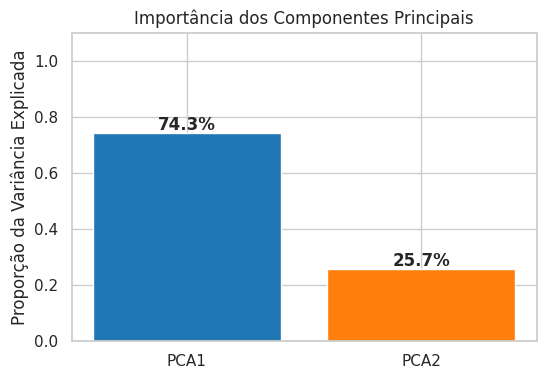


⚠️ PCA1 explica menos de 90% da variância. Usar apenas PCA1 pode levar à perda significativa de informação.


In [147]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# ===== 1) Selecionar apenas as colunas escaladas =====
# Aqui assumimos que df_scaled já existe com 'Age' e 'Fare' escalados entre 0 e 1
dados = df_scaled[['Age', 'Fare']]

# ===== 2) Tratar valores ausentes =====
# O PCA não aceita NaN, então usamos imputação simples (média)
imputer = SimpleImputer(strategy='mean')
dados_imputados = imputer.fit_transform(dados)

# ===== 3) Criar e ajustar o PCA =====
# Como temos duas features, pedimos 2 componentes principais
pca = PCA(n_components=2)
componentes = pca.fit_transform(dados_imputados)

# ===== 4) Criar DataFrame dos componentes principais =====
df_pca = pd.DataFrame(componentes, columns=['PCA1', 'PCA2'], index=df_scaled.index)
print("\nPrimeiras linhas com os novos componentes:")
print(df_pca.head())

# ===== 5) Obter os loadings (contribuição de cada variável para cada eixo) =====
loadings = pd.DataFrame(pca.components_,
                        columns=['Age', 'Fare'],
                        index=['PCA1', 'PCA2'])
print("\nLoadings dos componentes principais:")
print(loadings)

# ===== 6) Avaliar variância explicada =====
var_exp = pca.explained_variance_ratio_
print("\nVariância explicada por cada componente:", var_exp)
print("Variância explicada acumulada:", var_exp.cumsum())

# ===== 7) Visualização da variância explicada =====
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
plt.bar(['PCA1', 'PCA2'], var_exp, color=['#1f77b4', '#ff7f0e'])
plt.ylabel('Proporção da Variância Explicada')
plt.title('Importância dos Componentes Principais')
for i, v in enumerate(var_exp):
    plt.text(i, v + 0.01, f"{v*100:.1f}%", ha='center', fontweight='bold')
plt.ylim(0, 1.1)
plt.show()

# ===== 8) Decisão preliminar =====
if var_exp[0] >= 0.90:
    print("\n✅ PCA1 explica mais de 90% da variância. Pode ser viável substituir Age e Fare apenas por PCA1.")
else:
    print("\n⚠️ PCA1 explica menos de 90% da variância. Usar apenas PCA1 pode levar à perda significativa de informação.")

**9.4- Target Encoding**

**Até agora, quase todas as features categóricas já foram codificadas, apenas uma
 ainda resta. No item 9.2 foi criada a feature “Title”, a partir de “Name”, essa coluna contém
 diversos valores únicos, de forma que é promissora a utilização do Target Encoding para
 codificá-la. Esta estratégia utiliza a relação da feature categórica com o target para substituir
 seus valores, ou seja, é uma estratégia considerada de Supervised Learning. Para o target
 encoding será utilizado o algoritmo MEstimateEncoder.**

 **1. Deve-se então realizar o encoding da feature “Title”, após isso será interessante
 analisar a distribuição dos valores resultantes e compará-los com o target:**

 **a. Encoding da feature “Title”:**

 **i.Criar um encoder utilizando o M-estimators indicando qual feature será
 codificada e utilizando m = 5;**
 
 **ii.Criar um dataframe com os valores codificados da feature “Title”,
 utilizando o encoder, indicando a feature que será codificada e o target
 que será utilizado para codificação.**
 

In [148]:
#a)Encoding da feature:
#a.i)Criar um encoder MEstimateEncoder com m=5
# Se não tiver instalado:
!pip install category_encoders

import category_encoders as ce

# Criando o encoder M-Estimate
# cols indica quais colunas serão codificadas
encoder = ce.MEstimateEncoder(cols=['Title'], m=5)


In [149]:
#a.ii)Criar um Dataframe com os valores codificados

# Ajusta o encoder usando a relação Title -> Survived e transforma
title_encoded = encoder.fit_transform(df[['Title']], df['Survived'])

# Guarda o resultado em um novo DataFrame (ou pode adicionar ao df existente)
df_title_encoded = df.copy()
df_title_encoded['Title_encoded'] = title_encoded

# Visualizar as 10 primeiras linhas
print(df_title_encoded[['Title', 'Title_encoded']].head(10))

    Title  Title_encoded
0      Mr       0.158849
1     Mrs       0.776301
2    Miss       0.689407
3     Mrs       0.776301
4      Mr       0.158849
5      Mr       0.158849
6      Mr       0.158849
7  Master       0.553760
8     Mrs       0.776301
9     Mrs       0.776301


Text(0, 0.5, 'Frequência')

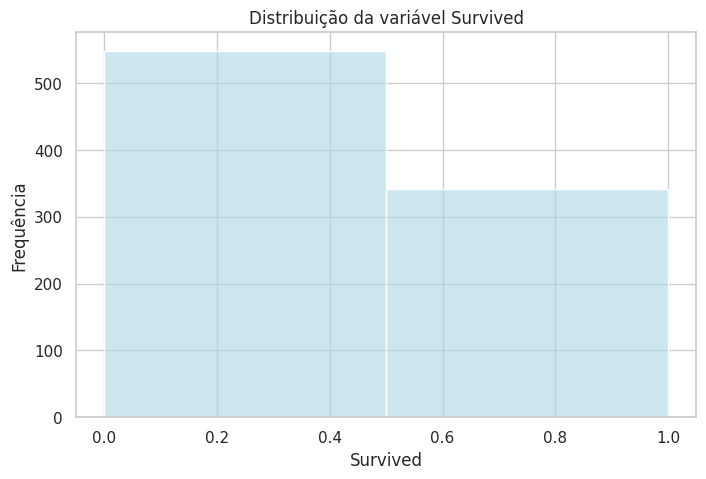

In [153]:
#b)Plot distribuição dos valores codificados:
#b.i)histograma e variável target(Survides)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df_title_encoded['Survived'], bins=2, color='lightblue', alpha=0.6)
plt.title('Distribuição da variável Survived')
plt.xlabel('Survived')
plt.ylabel('Frequência')

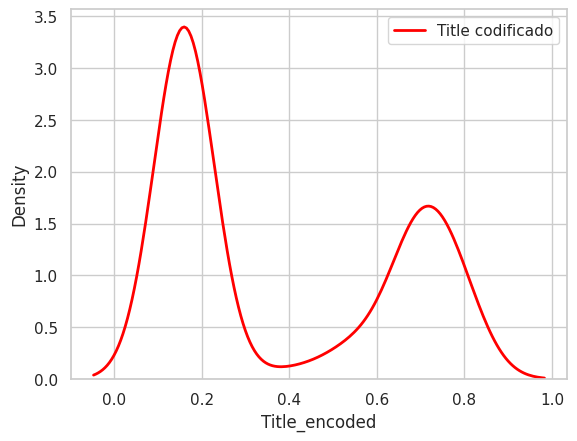

In [151]:
#b.ii)Sobrepor um KDE plot da coluna Title_encoded:

# KDE sobreposto
sns.kdeplot(df_title_encoded['Title_encoded'], color='red', label='Title codificado', linewidth=2)

# Legenda final
plt.legend()
plt.show()